# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

1. Risk profile of streets = https://wdl-data.fra1.digitaloceanspaces.com/pse/m_risk_prfile.zip
2. Excel explaining the categorical features : https://wdl-data.fra1.digitaloceanspaces.com/pse/Dictionary_Risk_Profiles.xlsx
2. OSM map = https://download.bbbike.org/osm/extract/planet_-9.89,38.265_-8.309,39.136.osm.pbf

## Introduction


When it comes to road safety, Portugal has one of the less impressive records in Europe, however, authorities have been taking steps in an attempt to improve the statistics; with fatalities dropping by 40% since 2010. Despite this, more than 400 people lost their lives in 2017 in road accidents and more than 40,000 injured.

An **European report** underlined these characteristics: 
- In Portugal, relatively many moped riders, lorry and truck occupants died in road accidents compared to the EU average.
- Portugal has a somewhat higher share of male road fatalities than the EU average.
- Fatalities in built-up areas, during daylight and while raining are overrepresented in Portugal.
- The number of speed tickets per population in Portugal is much lower than the EU average

Furthermore from our analysis we could see that there are three environments that where the pavement properties significantly, yet distinctly, influence the occurrence of accidents:

1. Rural environment with a heavy presence of urban characteristics
2. Environment characterized by a considerable predominance of intersections in a rural environment
3. Environment with curved segments, high longitudinal gradients and **average speed higher than the tolerable speed**




**HYPHOTHESIS** :


## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

### IMPORTING PACKAGES

In [1]:
# GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# LOADING DATA
import requests
import os
import shutil
from io import BytesIO
import osmium
import fiona
import json


# GEOSPATIAL DATA
from shapely.geometry import Point, LineString, MultiPoint
from shapely.geometry import shape 


# PLOTTING DATA
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.features import ColorLine, GeoJsonPopup, GeoJsonTooltip
from folium.map import FeatureGroup
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns

# STATS
import math
import stats

# ML
import scipy
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

### Extracting data

We decide to start clean and analyses the dataset given by the ***WDL*** team: a shape file containing 34678 different road segments. Each of these road segments is characterized by information on traffic intensity, velocity and environment in which this is inserted. 

In [5]:
def first_df(path):
    geo = gpd.read_file(path)
    df = pd.DataFrame(geo).drop(columns='Link_ID')
    df_ren = df.rename(columns={
                        'Daily_Aver':'Daily_Average_Traffic_Intensity',
                        'Average_Ve':'Average_Velocity_of_Vehicle_Traffic',
                        'Median_of_':'Median_of_velocity_of_Vehicle_Traffic',
                        'First_Quar': 'FirstQuartil_of_velocity_of_Vehicle_Traffic',
                        'Third_Quar': 'ThirdQuartil_of_velocity_of_Vehicle_Traffic'
                    })
    return df_ren
    
df = first_df('wdl_data/m_risk_prfile.geojson') 

To have a better understanding on our data and to avoid errors during our analysis we need to investigate it with general statistics.
To be able to trust our analysis we have to clean the dataset before. 

### Remove outliers: 

In [6]:
df.describe()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.816834,56.463409,43.822041,68.091844,2.684613,4.904781
std,2.355910e+08,2725.873982,51.983670,26.240876,24.442204,30.985191,0.538658,1.520568
min,8.021682e+07,14.435864,-401.703724,1.000000,-392.500000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.315321,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.966126,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.511585,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,6357.022296,1326.250000,143.000000,2605.000000,3.000000,7.000000


- Regarding the columns we know that they report values in km/h: many of the min and max we can observe thank to describe function don't make sense. 
- We need to operate on them as they are **outliers**

In [7]:
#removing outliers:
def rm_out(df):
    for i in df.columns.drop(['linkid', 'Daily_Average_Traffic_Intensity','geometry']):
        lb = 0
        ub = 180
#         print(lb, ub)
        df[i] = df[i].mask(df[i] < lb) 
        df[i] = df[i].mask(df[i] > ub) 
    return df

data = rm_out(df)

**If we run describe again we will see that the data regarding velocity has just feasible values.**

In [8]:
data.describe()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat
count,3.467800e+04,34678.000000,34633.000000,34675.000000,34677.000000,34674.000000,34678.000000,34678.000000
mean,8.958206e+08,3340.417942,56.112805,56.402803,43.834624,67.959767,2.684613,4.904781
std,2.355910e+08,2725.873982,24.346245,25.054113,24.329987,26.706718,0.538658,1.520568
min,8.021682e+07,14.435864,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000
25%,7.364832e+08,1903.398108,38.317003,38.250000,26.000000,48.000000,2.000000,4.000000
50%,9.067377e+08,2644.529317,49.961538,50.000000,38.875000,60.333333,3.000000,6.000000
75%,1.154997e+09,3897.886608,69.447459,71.000000,56.000000,85.000000,3.000000,6.000000
max,1.223731e+09,49309.806935,179.691892,143.250000,143.000000,164.000000,3.000000,7.000000


### Handling duplicates:

In [9]:
len(data) == len(data.drop_duplicates())

True

There are ***no duplicates*** in our dataset: NO ACTION NEEDED
    

### Handling missing values:

In [10]:
data.isnull().sum().sort_values(ascending=False) , f'Total of data points : {data.shape[0]}'

(Average_Velocity_of_Vehicle_Traffic            45
 ThirdQuartil_of_velocity_of_Vehicle_Traffic     4
 Median_of_velocity_of_Vehicle_Traffic           3
 FirstQuartil_of_velocity_of_Vehicle_Traffic     1
 linkid                                          0
 Daily_Average_Traffic_Intensity                 0
 Func_Class                                      0
 Speed_Cat                                       0
 geometry                                        0
 dtype: int64,
 'Total of data points : 34678')

As we can see the total highest number of missing values detected for column is 45 on a total number of rows of 34'678.
- The missing value for Average Velocity e the ones in Speed Difference Mean are the same (one column is created from the other one)
- The missing values of other column can be easily deleted

**As we are handling data regarding AVERAGE velocity we can easily substitute the missing values with the mean of the corresponding column**

In [12]:
def handling_missing(data):
    imputer = SimpleImputer()
    data['Average_Velocity_of_Vehicle_Traffic']=imputer.fit_transform(data[['Average_Velocity_of_Vehicle_Traffic']])
    return data.dropna()
data = handling_missing(data)

In [13]:
data.isnull().sum()

linkid                                         0
Daily_Average_Traffic_Intensity                0
Average_Velocity_of_Vehicle_Traffic            0
Median_of_velocity_of_Vehicle_Traffic          0
FirstQuartil_of_velocity_of_Vehicle_Traffic    0
ThirdQuartil_of_velocity_of_Vehicle_Traffic    0
Func_Class                                     0
Speed_Cat                                      0
geometry                                       0
dtype: int64

### Feature creation:

Now looking at our data we need to search for a target that in the next step we will use in our model.
Most common causes of Accidents:
- Over Speeding.
- Drunken Driving.
- Distractions to Driver.
- Red Light Jumping.
- Avoiding Safety Gears like Seat belts and Helmets.
- Non-adherence to lane driving and overtaking in a wrong manner.

The first cause is always the **over-speed** that can be connected with one of the above causes. 
For this reason we decide to investigate and use as target information regarding the velocity.

- Speed_Cat (described in the excel below)
- Average Velocity of Vehicle Traffic 
- Median of velocity of Vehicle Traffic

We will create a dictionary that, from the information contained in the excel can describe the type of street regarding the max velocity allowed in there.

In [14]:
speed_explanation = pd.read_excel('wdl_dict/Dictionary_Risk_Profiles.xlsx', sheet_name='SpeedCat')
speed_explanation

,Speed Cat,Speed range in km/h
0,1,>130 km/h
1,2,101-130 km/h
2,3,91-100 km/h
3,4,71-90 km/h
4,5,51-70 km/h
5,6,31-50 km/h
6,7,11-30 km/h
7,8,<11 km/h


from the table above we can create a dictionary.
1. count values for category
2. translate the speed range in actual number

In [15]:
data.Speed_Cat.value_counts()

6    20307
4     5273
2     5123
3     1843
5     1770
7      357
Name: Speed_Cat, dtype: int64

**NO need of mapping for label 1 and 8**

In [17]:
max_speed_dict = {2:130,3:100,4:90,5:70,6:50,7:30}
def target_creation(data):
    data['Max_speed'] = data['Speed_Cat'].map(max_speed_dict)
    data['Speed_Diff_Mean'] = data['Max_speed'] - data['Average_Velocity_of_Vehicle_Traffic']
    data['Speed_Diff_Median'] = data['Max_speed'] - data['Median_of_velocity_of_Vehicle_Traffic']
    return data
data = target_creation(data)

<ipython-input-17-97c7211f1675>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Max_speed'] = data['Speed_Cat'].map(max_speed_dict)
<ipython-input-17-97c7211f1675>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Speed_Diff_Mean'] = data['Max_speed'] - data['Average_Velocity_of_Vehicle_Traffic']
<ipython-input-17-97c7211f1675>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

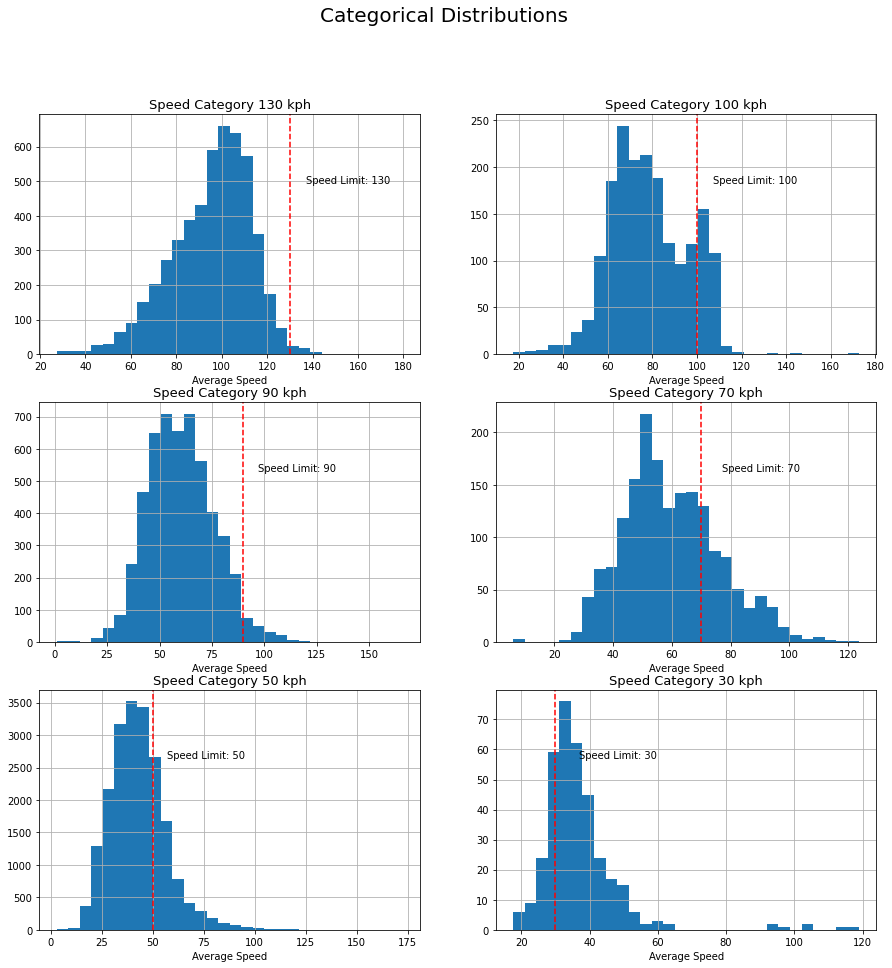

In [41]:
cat_list = {x:data[data['Max_speed']==x] for x in max_speed_dict.values()}
def speed_dist(cat_list):
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('Categorical Distributions', size=20)
#     fig.tight_layout()
    for c, i in enumerate(cat_list.items()):
        speedlim = i[0]
        plt.subplot(3, 2, c+1)
#         plt.set_xlabel('Average Speed')
        ax = i[1].Average_Velocity_of_Vehicle_Traffic.hist(bins=30)
        ylim = i[1].Average_Velocity_of_Vehicle_Traffic.value_counts(bins=30).max()
        ax.set_title(f'Speed Category {i[0]} kph', size=13)
        ax.set_xlabel('Average Speed')
        ax.axvline(speedlim, color='r', linestyle='--')
#         print(f'done {speedlim}, {ylim/2}, {speedlim}')
        ax.text(x=speedlim+7, y=float(ylim-ylim/4), s=f'Speed Limit: {speedlim}')
        
speed_dist(cat_list)

*Note*<br>
We can see that most over speeding is taking place at roads with lower speed limits such as *50 kph and 30 kph.*

**Over speeding behavior can be extracted by the deltas between the road's speed category and its actual average speed observations**

In [18]:
data[['Speed_Cat','Max_speed', 'Speed_Diff_Mean','Speed_Diff_Median']].head(10)

,Speed_Cat,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,6,50,4.791284,5.535714
1,4,90,10.436692,7.250000
2,6,50,-15.955069,-17.333333
3,6,50,2.466089,6.000000
4,6,50,-1.375291,-3.250000
5,6,50,17.667821,18.333333
6,6,50,19.613591,22.937500
7,6,50,26.714286,39.000000
8,6,50,6.476409,4.000000
9,6,50,-11.897045,1.346154


We believe that the main reason that is able to decrease the safety of a street is the speed rate.
**Our first target will be the difference between the mean of velocity and the max speed**

### Scaling features:

We are now ready to scale our dataframe to have a distribution *around* the mean.

1. We need to separate numerical and categorical column
2. We are going to use the Min-Max Scaling method for the numerical ones: is the one that is commonly used distance based algorithms, as k-means that is one of the possible analysis we are taking in consideration.  
3. For the categorical ones we'll use the OneHotEncoding method (for each label in each category creates a different column)

We could also operate this step all together but is important for us to know which column belong to each of the different classes inside the categorical feature. 
**To do so we need to operate for each categorical separately**

In [23]:
def scaling_numerical(data):
    numerical = data.columns.drop(['geometry','linkid','Speed_Cat', 'Func_Class'])
    scaler = MinMaxScaler()
    data_scaled = data.copy()
    for column in numerical:
        scaler.fit(data_scaled[[column]])
        data_scaled[column]=scaler.transform(data_scaled[[column]]) 
    return data_scaled
data_scaled = scaling_numerical(data)

1. **BEFORE SCALING**

In [24]:
data.drop(columns=['geometry','linkid','Speed_Cat', 'Func_Class']).head(1)

,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,6224.778569,45.208716,44.464286,28.0,59.0,50,4.791284,5.535714


2. **AFTER SCALING**

In [25]:
data_scaled.drop(columns=['geometry','linkid','Speed_Cat', 'Func_Class']).head(1)

,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Max_speed,Speed_Diff_Mean,Speed_Diff_Median
0,0.125982,0.247402,0.305549,0.195804,0.355828,0.2,0.565472,0.502626


**Working with the categorical features the first thing we need to do is to understand the distribution within the labels**

In [26]:
data.Func_Class.value_counts() , data.Speed_Cat.value_counts()

(3    25023
 2     8363
 1     1287
 Name: Func_Class, dtype: int64,
 6    20307
 4     5273
 2     5123
 3     1843
 5     1770
 7      357
 Name: Speed_Cat, dtype: int64)

- Functional Class has just 3 possible label for the street that we can understand better looking at the excel

In [27]:
func_explanation = pd.read_excel('wdl_dict/Dictionary_Risk_Profiles.xlsx', sheet_name='Func_Class')
for i,el in enumerate(func_explanation['Description']):
    print(f'Class n.{i+1} : {el} \n')

Class n.1 : These roads are meant for high volume, maximum speed traffic between and through major metropolitan areas. There are very few, if any, speed changes. Access to this road is usually controlled. 

Class n.2 : These roads are used to channel traffic to Main Roads (FRC1) for travel between and through cities in the shortest amount of time. There are very few, if any speed changes. 

Class n.3 : These roads interconnect First Class Roads (FRC2) and provide a high volume of traffic movement at a lower level of mobility than First Class Roads (FRC2). 



With this new and deeper understanding of the distribution and the meaning of the category (*NB: regarding speed_cat we can look back at the point **1.1.5 "Feature creation"** to get these informations)* we can now progress with our transformations.  

In [28]:
def scaling_categorical(data):
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(data[['Func_Class']])
    func_encoded = ohe.transform(data[['Func_Class']])
    data["func_1"],data["func_2"],data['func_3'] = func_encoded.T
    ohe = OneHotEncoder(sparse = False)
    ohe.fit(data[['Speed_Cat']])
    speed_encoded = ohe.transform(data[['Speed_Cat']])
    data["speed_2"],data["speed_3"],data["speed_4"],\
    data["speed_5"], data["speed_6"], data["speed_7"]= speed_encoded.T
    return data 

In [29]:
data_scaled = scaling_categorical(data_scaled)

### Preprocessed Dataframe: 

Here we have the first dataframe, the one given by the challenge, completely ready for the model.

In [33]:
data_scaled.head()

,linkid,Daily_Average_Traffic_Intensity,Average_Velocity_of_Vehicle_Traffic,Median_of_velocity_of_Vehicle_Traffic,FirstQuartil_of_velocity_of_Vehicle_Traffic,ThirdQuartil_of_velocity_of_Vehicle_Traffic,Func_Class,Speed_Cat,geometry,Max_speed,...,Speed_Diff_Median,func_1,func_2,func_3,speed_2,speed_3,speed_4,speed_5,speed_6,speed_7
0,80216819,0.125982,0.247402,0.305549,0.195804,0.355828,2,6,"MULTILINESTRING ((-9.16402 38.77030, -9.16389 ...",0.2,...,0.502626,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,80216858,0.045067,0.439658,0.574692,0.501748,0.565951,2,4,"MULTILINESTRING ((-9.16645 38.74274, -9.16638 ...",0.6,...,0.511029,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,80216859,0.043093,0.363503,0.466315,0.426573,0.453988,3,6,"MULTILINESTRING ((-9.16645 38.74274, -9.16637 ...",0.2,...,0.390523,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,80216860,0.044363,0.260414,0.302285,0.188112,0.447853,3,6,"MULTILINESTRING ((-9.16588 38.74370, -9.16568 ...",0.2,...,0.504902,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,80216867,0.042360,0.281911,0.367311,0.317016,0.355828,3,6,"MULTILINESTRING ((-9.16472 38.74478, -9.16487 ...",0.2,...,0.459559,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Feature engineering

We assume that ***over speeding*** is the main reason for road hazards. Over speeding behavior can be extracted by the deltas between the road's speed category and its actual average speed observations as processed in column ```Speed_Diff_Mean```. <br>

Over speeding can be harnessed among others by the roads environment [Source](https://www.tandfonline.com/doi/abs/10.1080/014416499295420). People chose their speeding behavior not only by speed limits but also by their assessment of the road's quality and the surrounding environment.<br>

Therefore we chose to gather more information about POIs, amenities and public buildings in the surrounding of the provided road segments. Those can be acquired through OSM sources.

### Scaling data set to Lisbon

waiting expl sisto

In [34]:
# Transforming pandas df to geopandas df
geo_df = gpd.GeoDataFrame(data_scaled)
geo_df.geometry[0].type

'MultiLineString'

In [35]:
## Filtering only lisbon data inside the circle of 38.72526068747401, -9.142352617846093 with buffer '1'
circle_lisbon = Point(-9.142352617846093, 38.72526068747401).buffer(1)
geo_lis = geo_df[geo_df.geometry.within(circle_lisbon)]
# no immediate usage of this pd.DataFrame
df_lis = pd.DataFrame(geo_lis).drop(columns=['geometry', 'linkid'])

In [36]:
print(f'The new data set has {df_lis.shape[0]} rows as opposed to the original set with {geo_df.shape[0]} rows')

The new data set has 17688 rows as opposed to the original set with 34673 rows


### Loading OSM Maps

In [37]:
%%bash
wget https://download.bbbike.org/osm/extract/planet_-9.89,38.265_-8.309,39.136.osm.pbf \
    --quiet -O map_data/Lisbon.osm.pbf

In [38]:
!ogrinfo map_data/Lisbon.osm.pbf

INFO: Open of `map_data/Lisbon.osm.pbf'
      using driver `OSM' successful.
1: points (Point)
2: lines (Line String)
3: multilinestrings (Multi Line String)
4: multipolygons (Multi Polygon)
5: other_relations (Geometry Collection)


In [39]:
%%bash
ogr2ogr -f "GPKG" \
     map_data/lisbon_polygons.gpkg \
     map_data/Lisbon.osm.pbf \
    -nlt POLYGONS \
    -nln polygons

0...10...20...30...40...50...60...70...80...90...100 - done.


Warning 1: A geometry of type POINT is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type LINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver will however do it. To create a conformant GeoPackage, if using ogr2ogr, the -nlt option can be used to override the layer geometry type. This warning will no longer be emitted for this combination of layer and feature geometry type.
Warning 1: A geometry of type MULTILINESTRING is inserted into layer polygons of geometry type POLYGON, which is not normally allowed by the GeoPackage specification, but the driver w

In [ ]:
#Read data
# about 3 mins
layer_file = "map_data/lisbon_polygons.gpkg"
collection = list(fiona.open(layer_file,'r'))
df1 = pd.DataFrame(collection)

#Check Geometry
def isvalid(geom):
    try:
        shape(geom)
        return 1
    except:
        return 0

df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
df1 = df1[df1['isvalid'] == 1]
collection = json.loads(df1.to_json(orient='records'))

#Convert to geodataframe
gdf_lis_poly = gpd.GeoDataFrame.from_features(collection)

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀